In [37]:

# 匯入必要模組
import glob
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

In [50]:
# 資料讀取與顯示
base_path = r'C:\Users\micha\Desktop\113deep\HW3\MVTec_AD_Dataset\cable'
file_paths = sorted(glob.glob(os.path.join(base_path, '**', '*.png'), recursive=True))
print(f"🔍 找到圖片總數：{len(file_paths)}")

all_data, valid_paths = [], []
for img_path in tqdm(file_paths):
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        all_data.append(img)
        valid_paths.append(img_path)
    else:
        print(f"❌ 無法讀取圖片：{img_path}")

if len(all_data) == 0:
    raise RuntimeError("🚨 沒有成功載入任何圖片")

all_data = np.stack(all_data)
print(f"✅ 成功載入圖片，shape: {all_data.shape}")

classes = sorted(set([os.path.basename(os.path.dirname(p)) for p in valid_paths]))
print(f'📦 類別: {classes}')

from collections import Counter

# 👉 類別總數與名稱
print(f"\n📌 缺陷類別總數（含 good）：{len(classes)}")
print("📌 類別名稱：", classes)

# 👉 圖片總數
print(f"📌 使用圖片總數：{len(valid_paths)}")

# 👉 統計每類圖片數（可推估 train/test 分佈）
label_counts = Counter([os.path.basename(os.path.dirname(p)) for p in valid_paths])
print("\n📊 每個類別的圖片數量：")
for cls in classes:
    print(f" - {cls}: {label_counts[cls]} 張")

# 👉 訓練/測試資料分佈推估
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')

n_train_imgs = len(glob.glob(os.path.join(train_path, '**', '*.png'), recursive=True))
n_test_imgs = len(glob.glob(os.path.join(test_path, '**', '*.png'), recursive=True))

print(f"\n🧪 訓練資料圖片數（推估）：{n_train_imgs}")
print(f"🧪 測試資料圖片數（推估）：{n_test_imgs}")

# 👉 圖片尺寸（取第一張圖查看）
sample_img = all_data[0]
print(f"\n🖼️ 圖片尺寸：{sample_img.shape[0]} x {sample_img.shape[1]}，通道數：{sample_img.shape[2]}")


🔍 找到圖片總數：466


  0%|          | 0/466 [00:00<?, ?it/s]

✅ 成功載入圖片，shape: (466, 1024, 1024, 3)
📦 類別: ['bent_wire', 'cable_swap', 'combined', 'cut_inner_insulation', 'cut_outer_insulation', 'good', 'missing_cable', 'missing_wire', 'poke_insulation']

📌 缺陷類別總數（含 good）：9
📌 類別名稱： ['bent_wire', 'cable_swap', 'combined', 'cut_inner_insulation', 'cut_outer_insulation', 'good', 'missing_cable', 'missing_wire', 'poke_insulation']
📌 使用圖片總數：466

📊 每個類別的圖片數量：
 - bent_wire: 26 張
 - cable_swap: 24 張
 - combined: 22 張
 - cut_inner_insulation: 28 張
 - cut_outer_insulation: 20 張
 - good: 282 張
 - missing_cable: 24 張
 - missing_wire: 20 張
 - poke_insulation: 20 張

🧪 訓練資料圖片數（推估）：224
🧪 測試資料圖片數（推估）：150

🖼️ 圖片尺寸：1024 x 1024，通道數：3


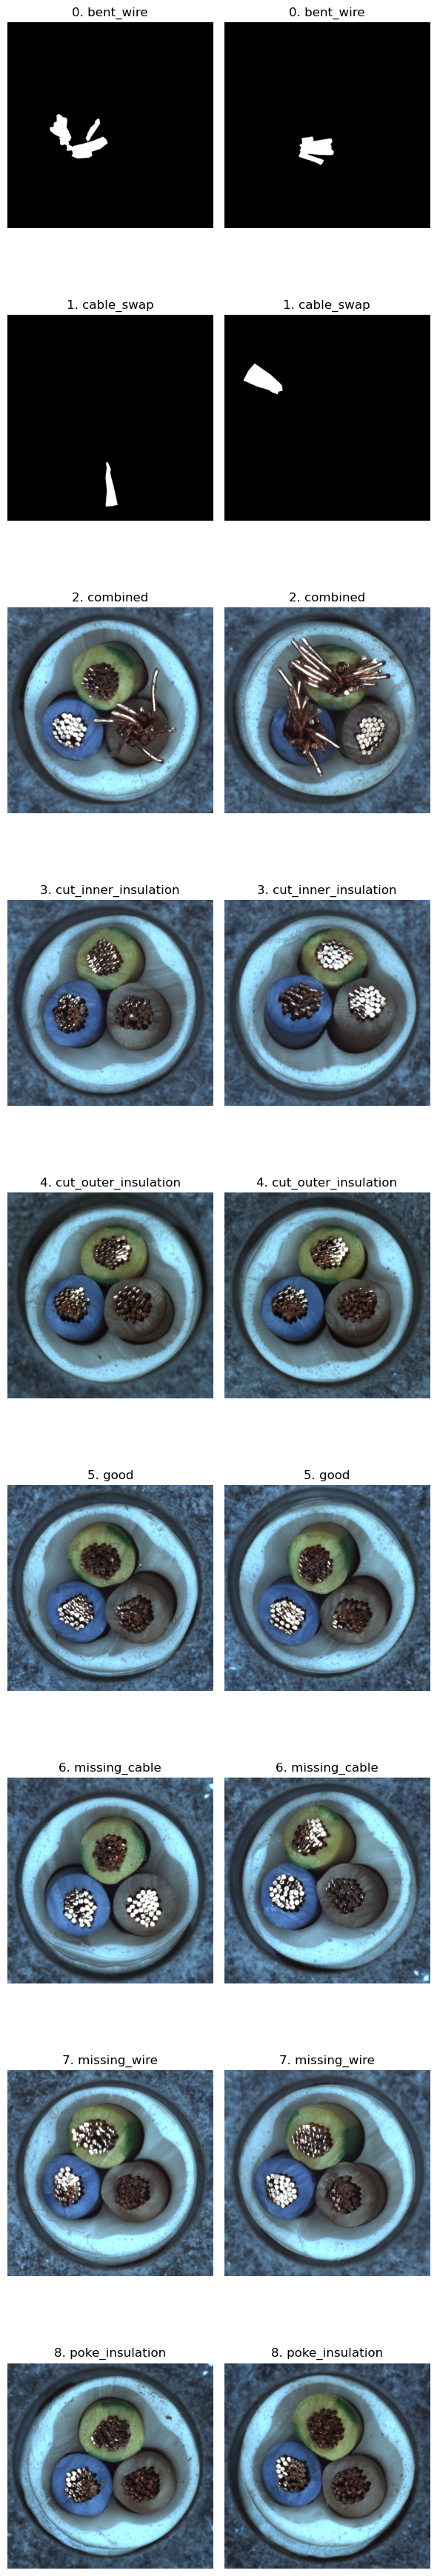

In [39]:
# 顯示每類別圖片
images_per_class = len(all_data) // len(classes)
fig, axs = plt.subplots(len(classes), 2, figsize=(6, 4 * len(classes)))
for i, class_name in enumerate(classes):
    index = i * images_per_class
    for j in range(2):
        axs[i, j].set_title(f'{i}. {class_name}')
        axs[i, j].imshow(all_data[index + j])
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()

In [40]:
# 建立 labels 並分割資料
labels = [classes.index(os.path.basename(os.path.dirname(p))) for p in valid_paths]
x_train, x_val, y_train, y_val = [], [], [], []
for class_idx in range(len(classes)):
    class_imgs = [all_data[i] for i in range(len(labels)) if labels[i] == class_idx]
    class_labels = [class_idx] * len(class_imgs)
    n_total = len(class_imgs)
    n_train = int(n_total * 0.8)
    if n_train == 0 or n_total - n_train == 0:
        print(f"⚠️ 類別 {classes[class_idx]} 資料過少，跳過。")
        continue
    x_train.extend(class_imgs[:n_train])
    y_train.extend(class_labels[:n_train])
    x_val.extend(class_imgs[n_train:])
    y_val.extend(class_labels[n_train:])

x_train = np.transpose(np.array(x_train), (0, 3, 1, 2))
x_val = np.transpose(np.array(x_val), (0, 3, 1, 2))
y_train = np.array(y_train)
y_val = np.array(y_val)


In [41]:
# 自訂 Dataset
class MyDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = torch.from_numpy(y).long()
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        img = np.transpose(self.x[idx], (1, 2, 0))
        img = Image.fromarray(img)
        return self.transform(img), self.y[idx]

In [42]:
from sklearn.utils.class_weight import compute_class_weight  # 新增這行

def train_model(model, x_train, y_train, x_val, y_val, tag, train_transforms, val_transforms, 
                early_stop=False, use_scheduler=False):
    import matplotlib.pyplot as plt

    def plot_accuracy_loss(train_accs, val_accs, train_losses, val_losses, save_path="acc_loss_plot.png"):
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_accs, label='Train')
        plt.plot(val_accs, label='Val')
        plt.title("Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_losses, label='Train')
        plt.plot(val_losses, label='Val')
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.tight_layout()
        plt.savefig(save_path)
        plt.show()

    model = model.cuda()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # ✅ 加入 class weight 處理資料不平衡
    class_weights_np = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weights = torch.tensor(class_weights_np, dtype=torch.float).cuda()
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    scheduler = CosineAnnealingLR(optimizer, T_max=50) if use_scheduler else None

    train_dataset = MyDataset(x_train, y_train, train_transforms)
    val_dataset = MyDataset(x_val, y_val, val_transforms)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    best_acc = 0
    patience, patience_counter = 7, 0
    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []

    for epoch in range(50):
        model.train()
        total_correct, total_loss = 0, 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset)
        train_accuracies.append(acc)
        train_losses.append(total_loss / len(train_loader))

        model.eval()
        val_correct = 0
        val_loss_total = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.cuda(), labels.cuda()
                out = model(imgs)
                val_loss = criterion(out, labels)
                val_loss_total += val_loss.item()
                val_correct += (out.argmax(1) == labels).sum().item()

        val_acc = val_correct / len(val_dataset)
        val_accuracies.append(val_acc)
        val_losses.append(val_loss_total / len(val_loader))

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f'best_{tag}.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            if early_stop and patience_counter >= patience:
                print(f"🛑 Early stopped at epoch {epoch+1}")
                break

        if scheduler:
            scheduler.step()

        print(f"[{tag}] Epoch {epoch+1}: Train Acc={acc:.4f}, Val Acc={val_acc:.4f}")

    plot_accuracy_loss(train_accuracies, val_accuracies, train_losses, val_losses, save_path=f"{tag}_acc_loss.png")
    return best_acc



In [43]:
# 四種策略函式
def train_finetune():
    model = models.resnet18(weights='IMAGENET1K_V1')
    for name, param in model.named_parameters():
        if 'layer4' in name or 'fc' in name:
            param.requires_grad = True
        else:
            param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, len(classes))
    tf = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
    return train_model(model, x_train, y_train, x_val, y_val, 'finetune', tf, tf)

In [44]:
def train_augmented():
    model = models.resnet18(weights='IMAGENET1K_V1')
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, len(classes))
    tf_train = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(0.3, 0.3, 0.2, 0.1),
        transforms.ToTensor()
    ])
    tf_val = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
    return train_model(model, x_train, y_train, x_val, y_val, 'augment', tf_train, tf_val)

In [45]:
def train_earlystop():
    model = models.resnet18(weights='IMAGENET1K_V1')
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, len(classes))
    tf = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
    return train_model(model, x_train, y_train, x_val, y_val, 'earlystop', tf, tf, early_stop=True)


In [46]:
def train_lrschedule():
    model = models.resnet18(weights='IMAGENET1K_V1')
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, len(classes))
    tf = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
    return train_model(model, x_train, y_train, x_val, y_val, 'lrschedule', tf, tf, use_scheduler=True)


In [47]:
def plot_accuracy_loss(train_accs, val_accs, train_losses, val_losses, save_path="acc_loss_plot.png"):
    plt.figure(figsize=(14, 5))

    # Accuracy 圖
    plt.subplot(1, 2, 1)
    plt.plot(train_accs, label='Train')
    plt.plot(val_accs, label='Val')
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss 圖
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Val')
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()


[finetune] Epoch 1: Train Acc=0.4703, Val Acc=0.0729
[finetune] Epoch 2: Train Acc=0.5541, Val Acc=0.5625
[finetune] Epoch 3: Train Acc=0.8081, Val Acc=0.6042
[finetune] Epoch 4: Train Acc=0.8622, Val Acc=0.6250
[finetune] Epoch 5: Train Acc=0.8730, Val Acc=0.6562
[finetune] Epoch 6: Train Acc=0.8919, Val Acc=0.6458
[finetune] Epoch 7: Train Acc=0.8541, Val Acc=0.6354
[finetune] Epoch 8: Train Acc=0.8703, Val Acc=0.6667
[finetune] Epoch 9: Train Acc=0.9514, Val Acc=0.6458
[finetune] Epoch 10: Train Acc=0.9378, Val Acc=0.6458
[finetune] Epoch 11: Train Acc=0.9486, Val Acc=0.6667
[finetune] Epoch 12: Train Acc=0.9459, Val Acc=0.6875
[finetune] Epoch 13: Train Acc=0.9568, Val Acc=0.6771
[finetune] Epoch 14: Train Acc=0.9432, Val Acc=0.6667
[finetune] Epoch 15: Train Acc=0.9351, Val Acc=0.6458
[finetune] Epoch 16: Train Acc=0.9568, Val Acc=0.6667
[finetune] Epoch 17: Train Acc=0.9568, Val Acc=0.6875
[finetune] Epoch 18: Train Acc=0.9676, Val Acc=0.6458
[finetune] Epoch 19: Train Acc=0.9676

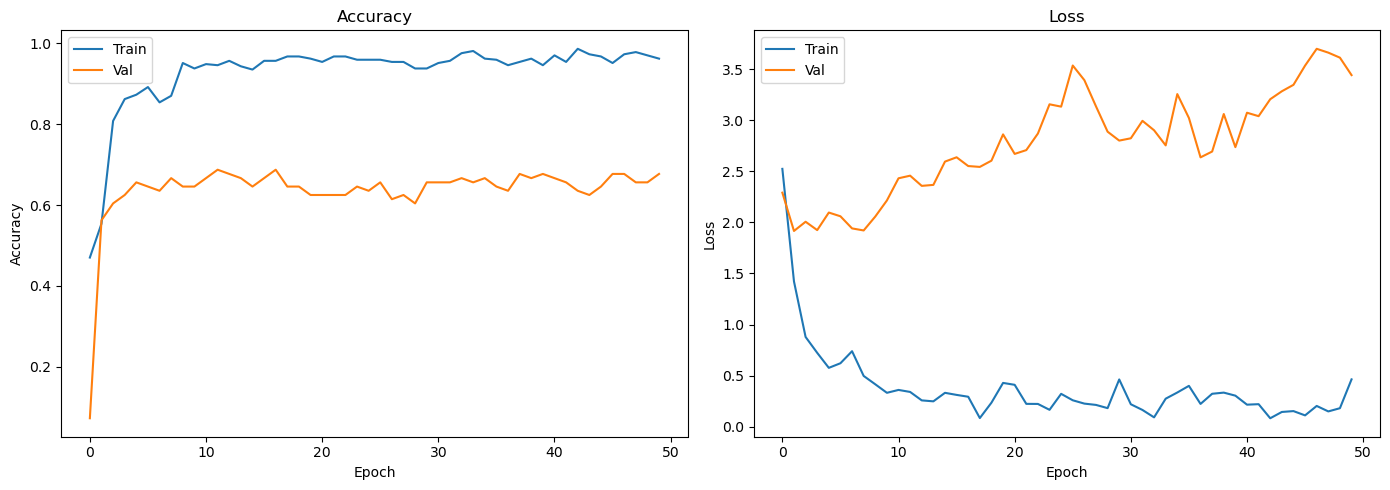

[augment] Epoch 1: Train Acc=0.2757, Val Acc=0.0833
[augment] Epoch 2: Train Acc=0.2243, Val Acc=0.0833
[augment] Epoch 3: Train Acc=0.4622, Val Acc=0.1354
[augment] Epoch 4: Train Acc=0.3541, Val Acc=0.2083
[augment] Epoch 5: Train Acc=0.5189, Val Acc=0.2188
[augment] Epoch 6: Train Acc=0.5595, Val Acc=0.2396
[augment] Epoch 7: Train Acc=0.3838, Val Acc=0.2708
[augment] Epoch 8: Train Acc=0.5135, Val Acc=0.3333
[augment] Epoch 9: Train Acc=0.5919, Val Acc=0.3542
[augment] Epoch 10: Train Acc=0.4865, Val Acc=0.2500
[augment] Epoch 11: Train Acc=0.5081, Val Acc=0.3854
[augment] Epoch 12: Train Acc=0.4865, Val Acc=0.3229
[augment] Epoch 13: Train Acc=0.5297, Val Acc=0.3646
[augment] Epoch 14: Train Acc=0.5135, Val Acc=0.4688
[augment] Epoch 15: Train Acc=0.5405, Val Acc=0.3229
[augment] Epoch 16: Train Acc=0.4919, Val Acc=0.3646
[augment] Epoch 17: Train Acc=0.4811, Val Acc=0.3438
[augment] Epoch 18: Train Acc=0.6027, Val Acc=0.4062
[augment] Epoch 19: Train Acc=0.4135, Val Acc=0.3125
[a

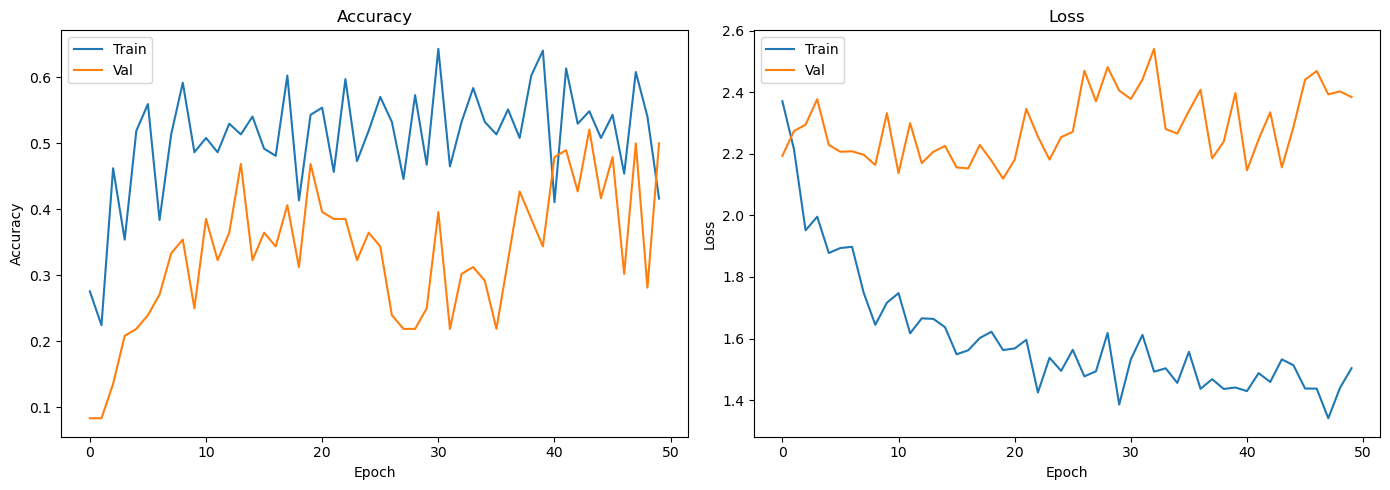

[earlystop] Epoch 1: Train Acc=0.2595, Val Acc=0.0833
[earlystop] Epoch 2: Train Acc=0.4135, Val Acc=0.3542
[earlystop] Epoch 3: Train Acc=0.5703, Val Acc=0.5104
[earlystop] Epoch 4: Train Acc=0.6595, Val Acc=0.6146
[earlystop] Epoch 5: Train Acc=0.5973, Val Acc=0.5729
[earlystop] Epoch 6: Train Acc=0.6595, Val Acc=0.5521
[earlystop] Epoch 7: Train Acc=0.6892, Val Acc=0.6042
[earlystop] Epoch 8: Train Acc=0.7108, Val Acc=0.6042
[earlystop] Epoch 9: Train Acc=0.6865, Val Acc=0.5208
[earlystop] Epoch 10: Train Acc=0.6973, Val Acc=0.5833
🛑 Early stopped at epoch 11


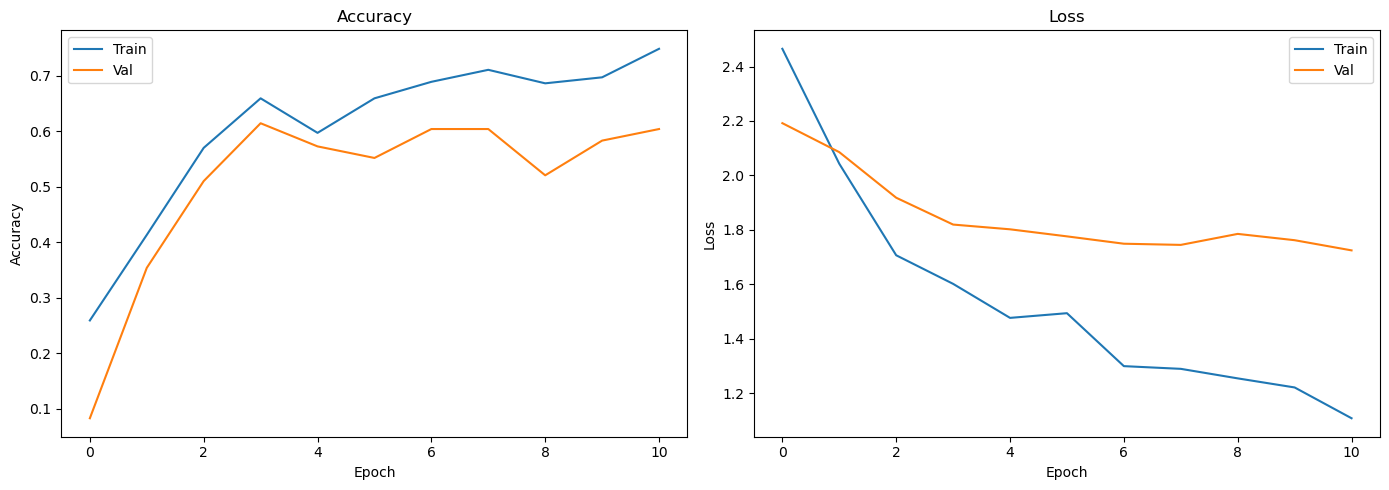

[lrschedule] Epoch 1: Train Acc=0.2378, Val Acc=0.0625
[lrschedule] Epoch 2: Train Acc=0.4730, Val Acc=0.3854
[lrschedule] Epoch 3: Train Acc=0.3324, Val Acc=0.4792
[lrschedule] Epoch 4: Train Acc=0.6135, Val Acc=0.5625
[lrschedule] Epoch 5: Train Acc=0.5784, Val Acc=0.5521
[lrschedule] Epoch 6: Train Acc=0.6324, Val Acc=0.5729
[lrschedule] Epoch 7: Train Acc=0.6270, Val Acc=0.5521
[lrschedule] Epoch 8: Train Acc=0.6649, Val Acc=0.5208
[lrschedule] Epoch 9: Train Acc=0.6378, Val Acc=0.5417
[lrschedule] Epoch 10: Train Acc=0.7595, Val Acc=0.5729
[lrschedule] Epoch 11: Train Acc=0.5568, Val Acc=0.4583
[lrschedule] Epoch 12: Train Acc=0.7324, Val Acc=0.5625
[lrschedule] Epoch 13: Train Acc=0.7216, Val Acc=0.5312
[lrschedule] Epoch 14: Train Acc=0.7649, Val Acc=0.5625
[lrschedule] Epoch 15: Train Acc=0.7351, Val Acc=0.5938
[lrschedule] Epoch 16: Train Acc=0.7946, Val Acc=0.5521
[lrschedule] Epoch 17: Train Acc=0.7432, Val Acc=0.5833
[lrschedule] Epoch 18: Train Acc=0.7243, Val Acc=0.5938
[

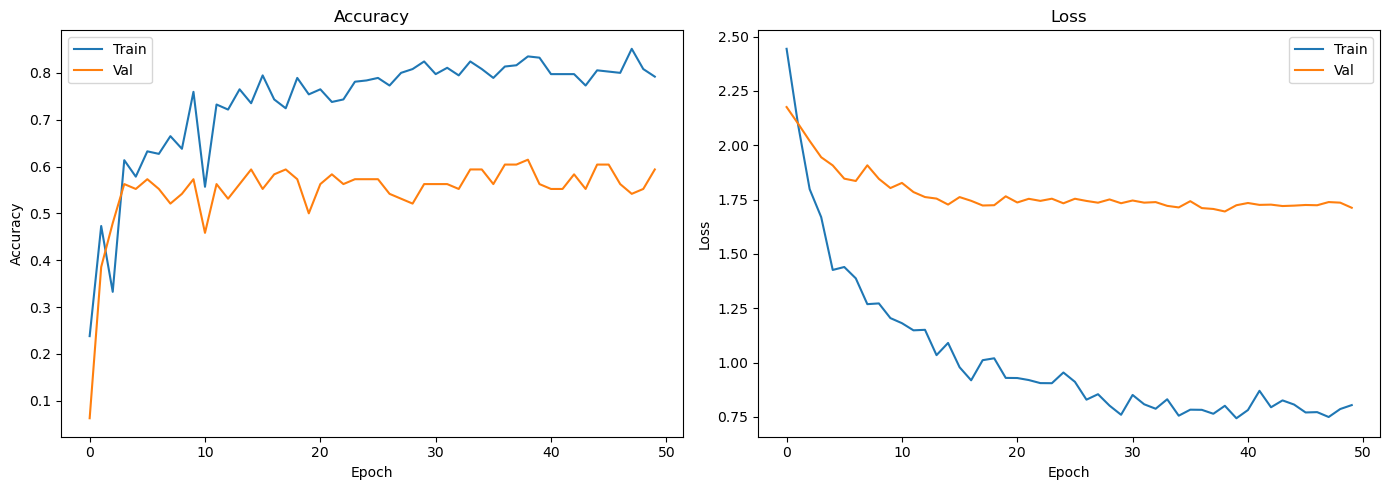


🎯 各方法最終驗證準確率：
1. Fine-tuning: 0.6875
2. Data Augmentation: 0.5208
3. Early Stopping: 0.6146
4. LR Scheduling: 0.6146


In [48]:
# 執行比較
acc1 = train_finetune()
acc2 = train_augmented()
acc3 = train_earlystop()
acc4 = train_lrschedule()

print("\n🎯 各方法最終驗證準確率：")
print(f"1. Fine-tuning: {acc1:.4f}")
print(f"2. Data Augmentation: {acc2:.4f}")
print(f"3. Early Stopping: {acc3:.4f}")
print(f"4. LR Scheduling: {acc4:.4f}")